In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
data = pd.read_csv("project4.csv")

In [2]:
## treating "?" values in node-caps with "no" because that is the "mode" or most frequent value
data["node-caps"] = data["node-caps"].replace("?","no")

In [3]:
## treating "?" values in breast-quad with "left_low" because that is the "mode" or most frequent value
data["breast-quad"] = data["breast-quad"].replace("?","left_low")

In [4]:
## converting columns to category type for one-hot encoding
data['class'] = data['class'].astype("category")
data['menopause'] = data['menopause'].astype("category")
data['node-caps'] = data['node-caps'].astype("category")
data['breast'] = data['breast'].astype("category")
data['breast-quad'] = data['breast-quad'].astype("category")
data['irradiat'] = data['irradiat'].astype("category")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   class        286 non-null    category
 1   age          286 non-null    object  
 2   menopause    286 non-null    category
 3   tumor-size   286 non-null    object  
 4   inv-nodes    286 non-null    object  
 5   node-caps    286 non-null    category
 6   deg-malig    286 non-null    int64   
 7   breast       286 non-null    category
 8   breast-quad  286 non-null    category
 9   irradiat     286 non-null    category
dtypes: category(6), int64(1), object(3)
memory usage: 11.6+ KB


In [6]:
data = pd.get_dummies(data, columns=["class", "menopause", "node-caps", 'breast','breast-quad','irradiat'], drop_first=True)

In [7]:
## doing data type conversion on age, tumor-size, and inv-nodes by replacing ranges with their midpoint
data["age"] = data["age"].replace({'20-29':'25', '30-39':'35','40-49':'45','50-59':'55','60-69':'65','70-79':'75'})
data["tumor-size"] = data["tumor-size"].replace({'0-4':'2', '5-9':'7','10-14':'12','15-19':'17','20-24':'22','25-29':'27', '30-34':'32','35-39':'37','40-44':'42','45-49':'47','50-54':'52'})
data["inv-nodes"] = data["inv-nodes"].replace({'0-2':'1', '3-5':'4','6-8':'7','9-11':'10','12-14':'13','15-17':'16','24-26':'25'})

In [8]:
## converting the columns to ints
data["age"] = data["age"].astype(int)
data["tumor-size"] = data["tumor-size"].astype(int)
data["inv-nodes"] = data["inv-nodes"].astype(int)

In [9]:
data.drop_duplicates(inplace=True, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   age                      272 non-null    int64
 1   tumor-size               272 non-null    int64
 2   inv-nodes                272 non-null    int64
 3   deg-malig                272 non-null    int64
 4   class_recurrence-events  272 non-null    bool 
 5   menopause_lt40           272 non-null    bool 
 6   menopause_premeno        272 non-null    bool 
 7   node-caps_yes            272 non-null    bool 
 8   breast_right             272 non-null    bool 
 9   breast-quad_left_low     272 non-null    bool 
 10  breast-quad_left_up      272 non-null    bool 
 11  breast-quad_right_low    272 non-null    bool 
 12  breast-quad_right_up     272 non-null    bool 
 13  irradiat_yes             272 non-null    bool 
dtypes: bool(10), int64(4)
memory usage: 11.3 KB


In [10]:
X = data.drop('class_recurrence-events', axis=1)
y = data['class_recurrence-events']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [11]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import xgboost as xgb

In [13]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}
# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the RandomizedSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy',n_jobs=-1)

# Fit the RandomizedSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 1.0}
Best score:  0.7631578947368421


In [14]:
from sklearn.metrics import classification_report

In [15]:
acc_xgb = grid_search.best_estimator_
print(f"Performance on TEST\n*******************\n{classification_report(y_test, acc_xgb.predict(x_test))}")
print(f"Performance on TRAIN\n********************\n{classification_report(y_train, acc_xgb.predict(x_train))}")


Performance on TEST
*******************
              precision    recall  f1-score   support

       False       0.77      0.91      0.83        58
        True       0.62      0.33      0.43        24

    accuracy                           0.74        82
   macro avg       0.69      0.62      0.63        82
weighted avg       0.72      0.74      0.72        82

Performance on TRAIN
********************
              precision    recall  f1-score   support

       False       0.77      0.97      0.86       133
        True       0.82      0.32      0.46        57

    accuracy                           0.77       190
   macro avg       0.79      0.64      0.66       190
weighted avg       0.78      0.77      0.74       190



In [16]:

# Create the RandomizedSearchCV object
grid_recall = GridSearchCV(xgb_model, param_grid, cv=5, scoring='recall',n_jobs=-1)

# Fit the RandomizedSearchCV object to the training data
grid_recall.fit(x_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_recall.best_params_)
print("Best score: ", grid_recall.best_score_)

Best set of hyperparameters:  {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.8}
Best score:  0.43484848484848476


In [17]:
recall_xgb = grid_recall.best_estimator_
print(f"Performance on TEST\n*******************\n{classification_report(y_test, recall_xgb.predict(x_test))}")
print(f"Performance on TRAIN\n********************\n{classification_report(y_train, recall_xgb.predict(x_train))}")


Performance on TEST
*******************
              precision    recall  f1-score   support

       False       0.79      0.90      0.84        58
        True       0.62      0.42      0.50        24

    accuracy                           0.76        82
   macro avg       0.71      0.66      0.67        82
weighted avg       0.74      0.76      0.74        82

Performance on TRAIN
********************
              precision    recall  f1-score   support

       False       0.85      0.94      0.89       133
        True       0.81      0.61      0.70        57

    accuracy                           0.84       190
   macro avg       0.83      0.78      0.80       190
weighted avg       0.84      0.84      0.84       190



In [18]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': np.arange(3, 20, 1),
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8],
    'gamma': [0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

In [19]:
# Create the RandomizedSearchCV object
grid_recall2 = GridSearchCV(xgb_model, param_grid, cv=5, scoring='recall',n_jobs=-1)

# Fit the RandomizedSearchCV object to the training data
grid_recall2.fit(x_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_recall2.best_params_)
print("Best score: ", grid_recall2.best_score_)

Best set of hyperparameters:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best score:  0.41818181818181815


In [20]:
recall_xgb2 = grid_recall2.best_estimator_
print(f"Performance on TEST\n*******************\n{classification_report(y_test, recall_xgb2.predict(x_test))}")
print(f"Performance on TRAIN\n********************\n{classification_report(y_train, recall_xgb2.predict(x_train))}")


Performance on TEST
*******************
              precision    recall  f1-score   support

       False       0.77      0.83      0.80        58
        True       0.50      0.42      0.45        24

    accuracy                           0.71        82
   macro avg       0.64      0.62      0.63        82
weighted avg       0.69      0.71      0.70        82

Performance on TRAIN
********************
              precision    recall  f1-score   support

       False       0.84      0.95      0.89       133
        True       0.82      0.58      0.68        57

    accuracy                           0.84       190
   macro avg       0.83      0.76      0.79       190
weighted avg       0.84      0.84      0.83       190



In [21]:
import pickle
with open('acc_xgb', 'wb') as f:
    pickle.dump(acc_xgb, f)

In [22]:
with open('recall_xgb', 'wb') as f:
    pickle.dump(recall_xgb, f)

In [23]:
with open('recall_xgb2', 'wb') as f:
    pickle.dump(recall_xgb2, f)

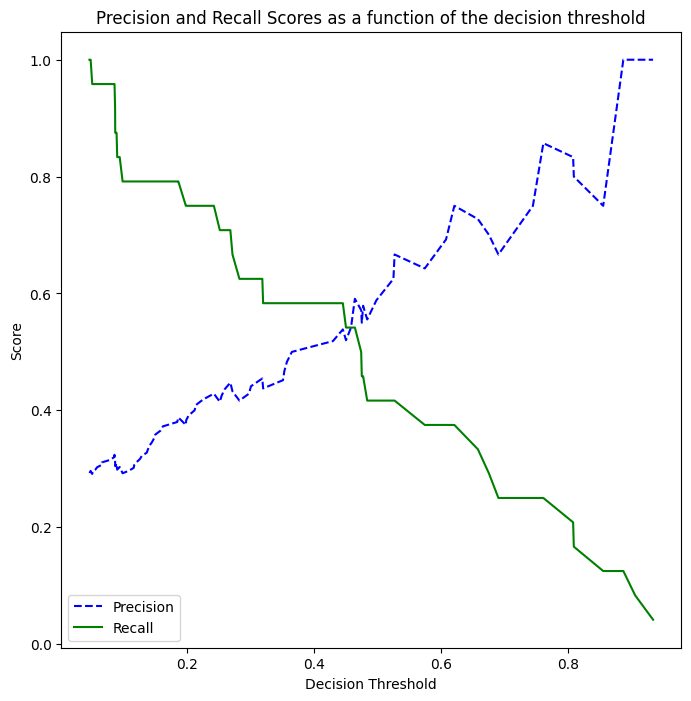

In [26]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

# generate the probabilities on the test set; here we could use any model
Y_probs = recall_xgb.predict_proba(x_test)[0:,1]

# the precision_recall_curve function from sklearn returns three parameters
precisions, recalls, thresholds = precision_recall_curve(y_test, Y_probs)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

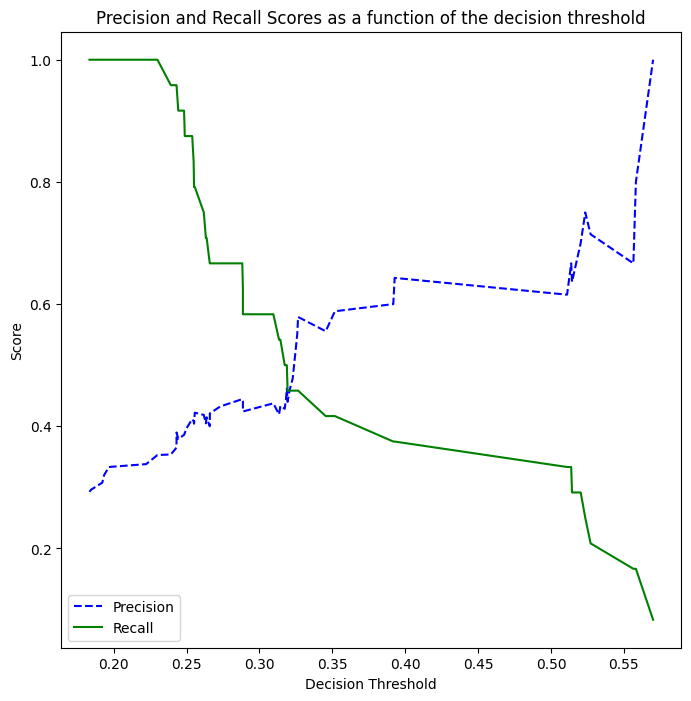

In [27]:
Y_probs = acc_xgb.predict_proba(x_test)[0:,1]

# the precision_recall_curve function from sklearn returns three parameters
precisions, recalls, thresholds = precision_recall_curve(y_test, Y_probs)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

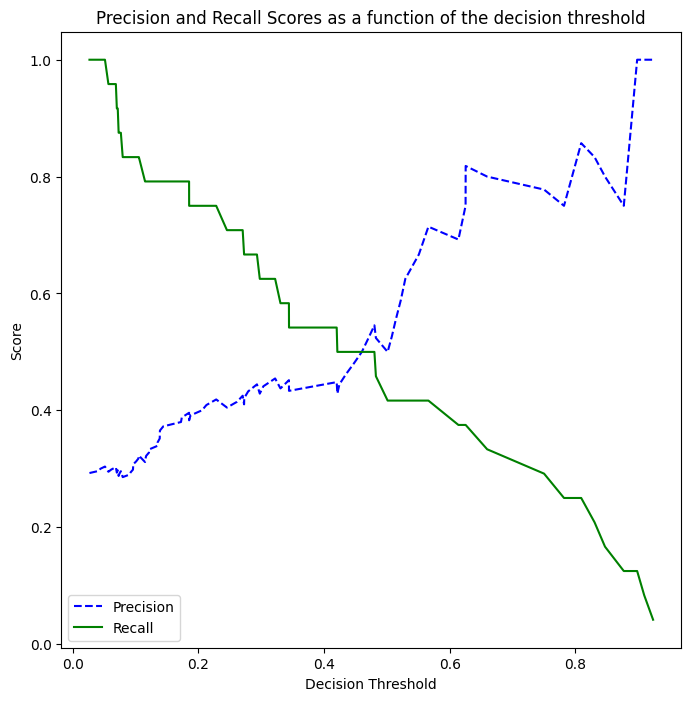

In [28]:
Y_probs = recall_xgb2.predict_proba(x_test)[0:,1]

# the precision_recall_curve function from sklearn returns three parameters
precisions, recalls, thresholds = precision_recall_curve(y_test, Y_probs)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)